In [1]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import string
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
from pandas import DataFrame
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

The XGBoost Model in this notebook is trained using publically available building permit data fetched from:
data.sfgov.org/Housing-and-Buildings/Building-Permits/i98e-djp9/about_data

and housing data fetched from: 
redfin-public-data.s3.us-west-2.amazonaws.com/redfin_covid19/weekly_housing_market_data_most_recent. 

The label to be predicted is the adjusted average homes sold where the data around building permits is used to predict future weekly home sales in the SF metro area. 

In [2]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

In [3]:
#This how the Redfin data is cleaned
#Fetched from https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_covid19/weekly_housing_market_data_most_recent.tsv000

df = pd.read_csv(ipynb_path + "/weekly_housing_market_data_most_recent.tsv", delimiter='\t', parse_dates=['period_begin','period_end'])
df = df[df["region_id"].isin([340, 41884])]

#Selected data calculated per the one week interval and for the metro (-2) region type identifier.
df = df[df['duration'] == '1 weeks']
df = df[df['region_type_id'] == -2]

column_names = df.columns.tolist()
column_names.sort()

In [4]:
#Included are columns of data dropped from the SF housing dataset and is not used in the prediction algorithim 

df = df.drop(columns=[
 'active_listings_yoy',
 'adjusted_average_homes_sold_yoy',
 'adjusted_average_new_listings',
 'adjusted_average_new_listings_yoy',
 'age_of_inventory',
 'age_of_inventory_yoy',
 'average_pending_sales_listing_updates',
 'average_pending_sales_listing_updates_yoy',
 'average_sale_to_list_ratio',
 'average_sale_to_list_ratio_yoy',
 'median_days_on_market',
 'median_days_on_market_yoy',
 'median_days_to_close',
 'median_days_to_close_yoy',
 'median_new_listing_ppsf',
 'median_new_listing_ppsf_yoy',
 'median_new_listing_price',
 'median_new_listing_price_yoy',
 'median_pending_sqft',
 'median_pending_sqft_yoy',
 'median_sale_ppsf',
 'median_sale_ppsf_yoy',
 'median_sale_price',
 'median_sale_price_yoy',
 'months_of_supply',
 'months_of_supply_yoy',
 'off_market_in_two_weeks',
 'off_market_in_two_weeks_yoy',
 'percent_active_listings_with_price_drops',
 'percent_active_listings_with_price_drops_yoy'
])
             
df.to_csv(ipynb_path +  "/sf_data.csv")

list(df.columns)

['period_begin',
 'period_end',
 'region_type',
 'region_type_id',
 'region_name',
 'region_id',
 'duration',
 'adjusted_average_homes_sold',
 'active_listings']

In [5]:
#This how the SF Building Permit data is cleaned. Fetched from data.sfgov.org/Housing-and-Buildings/Building-Permits/i98e-djp9/about_data

bp = pd.read_csv("Building_Permits.csv",dtype={'Voluntary Soft-Story Retrofit': 'str',
                                               'Fire Only Permit': 'str',
                                               'TIDF Compliance': 'str',
                                               'Proposed Construction Type': 'str'},
                 parse_dates=['Permit Creation Date',
                              'Current Status Date',
                              'Filed Date','Issued Date',
                              'Completed Date',
                              'First Construction Document Date'],
                 infer_datetime_format=True)

bp = bp.set_index('Record ID')
bp.drop(bp[bp['Location'].isna()].index, inplace=True)
bp['Wait Time'] = (bp['Issued Date'] - bp['Filed Date']).astype('timedelta64[D]')
bp = bp.drop(columns=['Description','Supervisor District',
                      'Neighborhoods - Analysis Boundaries',
                      'Street Number','Street Name',
                      'Street Suffix',
                      'Permit Number',
                      'Completed Date',
                      'Number of Existing Stories',
                      'Number of Proposed Stories',
                      #'Permit Expiration Date',
                      'Estimated Cost',
                      'Revised Cost',
                      'Existing Use',
                      'Existing Units',
                      'Proposed Use',
                      'Plansets',
                      'Proposed Units',
                      'Street Number Suffix',
                      'Existing Construction Type',
                      'Existing Construction Type Description',
                      'Proposed Construction Type',
                      'Proposed Construction Type Description',
                      'Voluntary Soft-Story Retrofit','Fire Only Permit',
                      'First Construction Document Date',
                      'Structural Notification',
                      'Unit',
                      'Unit Suffix',
                      'Permit Type Definition',
                      'Site Permit',
                      'TIDF Compliance',
                      'SF Find Neighborhoods 2',
                      'Current Police Districts 2',
                      'Current Supervisor Districts 2',
                      'Analysis Neighborhoods 2',
                      'DELETE - Zip Codes 2',
                      'DELETE - Fire Prevention Districts 2',
                      'DELETE - Supervisor Districts 2',
                      'DELETE - Current Police Districts 2',
                      'DELETE - Supervisorial_Districts_Waterline_data_from_7pkg_wer3 2',
                      'Point Source',
                      'data_as_of',
                      'data_loaded_at'
                      
                     ])
bp['Filed Year'] = pd.DatetimeIndex(bp['Filed Date']).year

bp.to_csv(ipynb_path +  "/bp_scrubbed.csv")

C:\Users\Sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3397: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# This is the import of both the scrubbed/cleaned Redfin and SF Building Permit data.
bp = pd.read_csv(ipynb_path +  "/bp_scrubbed.csv")
sf = pd.read_csv(ipynb_path +  "/sf_data.csv")

In [7]:
# Gives the number of null values in the downloaded Building permit dataframe
bp.isnull().sum()

Record ID                             0
Permit Type                           0
Permit Creation Date                  0
Block                                 0
Lot                                   0
Current Status                       12
Current Status Date                  12
Filed Date                          188
Issued Date                       61506
Existing Occupancy               173738
Proposed Occupancy               163434
Last Permit Activity Date         99789
Application Submission Method         0
ADU                                   0
Primary Address Flag             140982
Zipcode                              89
Location                              0
Neighborhoods                        74
Wait Time                         61509
Filed Year                          188
dtype: int64

In [8]:
# Section drops the the empty wait time rows

bp.dropna(subset=['Wait Time'], inplace=True)

bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176347 entries, 0 to 1237855
Data columns (total 20 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Record ID                      1176347 non-null  int64  
 1   Permit Type                    1176347 non-null  int64  
 2   Permit Creation Date           1176347 non-null  object 
 3   Block                          1176347 non-null  object 
 4   Lot                            1176347 non-null  object 
 5   Current Status                 1176347 non-null  object 
 6   Current Status Date            1176347 non-null  object 
 7   Filed Date                     1176347 non-null  object 
 8   Issued Date                    1176347 non-null  object 
 9   Existing Occupancy             1011896 non-null  object 
 10  Proposed Occupancy             1019818 non-null  object 
 11  Last Permit Activity Date      1098690 non-null  object 
 12  Application Su

In [9]:
# Removes Buidling permit row with no zip code of neighboorhood and assigns data type to several columns

bp = bp[bp.Zipcode != '']
bp = bp[bp.Neighborhoods != '']

for col in ['Block','Lot','Current Status']:
    bp[col] = bp[col].astype('string')
for col in ['Zipcode','Neighborhoods']:
    bp[col] = bp[col].astype('float')
for col in ['Permit Creation Date','Current Status Date','Filed Date','Issued Date']:
    bp[col] = bp[col].astype('datetime64[ns]')
    
bp.dtypes

Record ID                                 int64
Permit Type                               int64
Permit Creation Date             datetime64[ns]
Block                                    string
Lot                                      string
Current Status                           string
Current Status Date              datetime64[ns]
Filed Date                       datetime64[ns]
Issued Date                      datetime64[ns]
Existing Occupancy                       object
Proposed Occupancy                       object
Last Permit Activity Date                object
Application Submission Method            object
ADU                                      object
Primary Address Flag                     object
Zipcode                                 float64
Location                                 object
Neighborhoods                           float64
Wait Time                               float64
Filed Year                              float64
dtype: object

In [10]:
# Sets the filed year column to datatype datetime.year. Year is used to separate data for training.

bp['Filed Year'] = pd.DatetimeIndex(bp['Filed Date']).year
bp.head(50)

Record ID  Permit Type Permit Creation Date  Block   Lot  \
0    787771373024            4           1994-03-01   3723   115   
1   1485381413765            8           2017-10-31  0467A   005   
2   1484765235843            8           2017-10-25   0605  018B   
3   1483861234612            8           2017-10-18   0497  004A   
4    821280158698            8           2000-06-16   3561   052   
5    361539294710            7           1991-11-19   0116  020A   
6    900829209180            8           2002-02-07   6614   024   
7    899719107674            8           2002-01-25   1632  009F   
8    899364208549            8           2002-01-23   6594   023   
9     99458862824            8           2004-10-01   0220   008   
10    99412166836            8           2004-09-28   0280   031   
12  1363470501920            8           2014-11-24   0334   005   
13  1362394153653            8           2014-11-14   3148   024   
14  1473274458174            8           2017-08-03   1275   067   
15   127476061296            8           2012-06-28   0162   003   
16   105432877796            8           2006-05-25   0652   001   
17  1299759157596            8           2013-03-25   3543   011   
18  1299554303495            8           2013-03-22   0527   009   
19  1298612376599            8           2013-03-13   1020   016   
20     8790889459            4           1984-09-25   1098   038   
21  1507709304764            8           2018-05-10   0591   018   
22  1507844386375            8           2018-05-11   0246   001   
23  1507552228233            8           2018-05-10   7542   040   
24  1507380392309            8           2018-05-09   0221   152   
25  1378689232445            8           2015-04-20   0181   005   
26   884706288161            8           2001-08-07   3594   073   
27   878111104537            8           2001-05-23   1562   033   
28  1050066207730            8           2006-04-19   6566  022A   
29  1371103164367            8           2015-02-13   3704   001   
30  1691161107326            8           2024-03-22   1624  005A   
31  1051494256839            8           2006-05-01   0958   030   
32  1049342153137            8           2006-04-11   3137   013   
33  1375929186596            8           2015-03-27   5674  008A   
34  1037227152313            8           2005-12-02   3095   066   
35   583838183856            8           1996-08-07   5535   028   
36   875903152156            8           2001-04-30   3092   046   
37   793285367015            8           1996-08-13   0533   013   
38   137082287055            8           2015-02-11   1011   021   
39    28259198840            3           1990-04-06   1416   030   
40   883212347312            8           2001-07-20   3705   048   
41  1691824361340            8           2024-04-01   1895   001   
42  1037046265799            8           2005-11-30   0119   028   
43  1212608303474            8           2010-07-21   0535   009   
44  1699186158828            8           2024-07-03   3564   030   
45  1035941107687            8           2005-11-17   1632   011   
46   584957124060            8           1996-08-13   2063   009   
47  1215287378803            8           2010-08-17   0653   021   
48   884745390232            8           2001-08-07   0927   024   
49   153745194383            8           2019-01-09  1265A   022   
50   886495157684            8           2001-08-27   3545   009   

   Current Status Current Status Date          Filed Date         Issued Date  \
0        complete 1994-06-17 00:00:00 1994-03-01 00:00:00 1994-03-25 00:00:00   
1          issued 2017-10-31 07:48:57 2017-10-31 07:43:33 2017-10-31 07:48:57   
2          issued 2017-10-25 15:03:18 2017-10-25 15:01:02 2017-10-25 15:03:18   
3          issued 2017-10-18 15:59:13 2017-10-18 11:19:56 2017-10-18 15:59:13   
4         expired 2000-10-16 09:06:36 2000-06-16 09:04:45 2000-06-16 09:06:36   
5        complete 1992-05-13 00:00:00 1991-11-19 00:0

In [11]:
# Creates groupby object in order to perform statistical analysis (aka .describe() function)

group_year = bp.groupby('Filed Year')

groupy_stats = group_year.describe()

In [12]:
# Drops the nested data for the following years because of limited amount of Building permit data

groupy_stats = groupy_stats.drop(index=[1901,1908,1909,1929,1949,1968])

<Figure size 7200x1800 with 0 Axes>

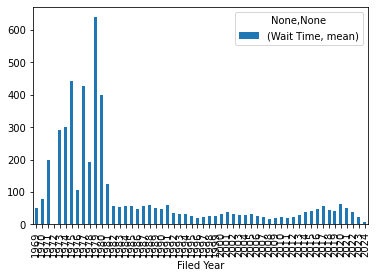

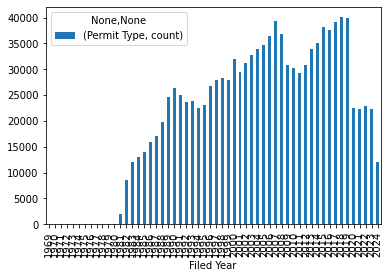

In [13]:
# Plots the figures using pandas basic plot function

plt.figure(figsize=(100,25))

groupy_stats.plot.bar(y=('Wait Time', 'mean'), use_index=True);

groupy_stats.plot.bar(y=('Permit Type', 'count'), use_index=True);

In [14]:
# Function returns a tuple of the longitude and latitude using an inputted dataframe and year 

def longlat(df, year):
    
    long = []
    lat = []
    
    dfy = df[df['Filed Year'] == year]
    
    for x in range (len(dfy)):
        loc = str(dfy['Location'].iloc[x])
        
        data = loc.strip().split(" ")
        z = data[1][1:]
        y = data[2][:-1]
        
        long.append(float(z))
        lat.append(float(y))
        
            
    while('nan' in long):
        long.remove('nan')

    while('nan' in lat):
        lat.remove('nan')
    
    return long,lat

In [15]:
tuple = longlat(bp, 1990)

bp1990 = bp[bp['Filed Year'] == 1990]

long = tuple[0]
lat = tuple[1]

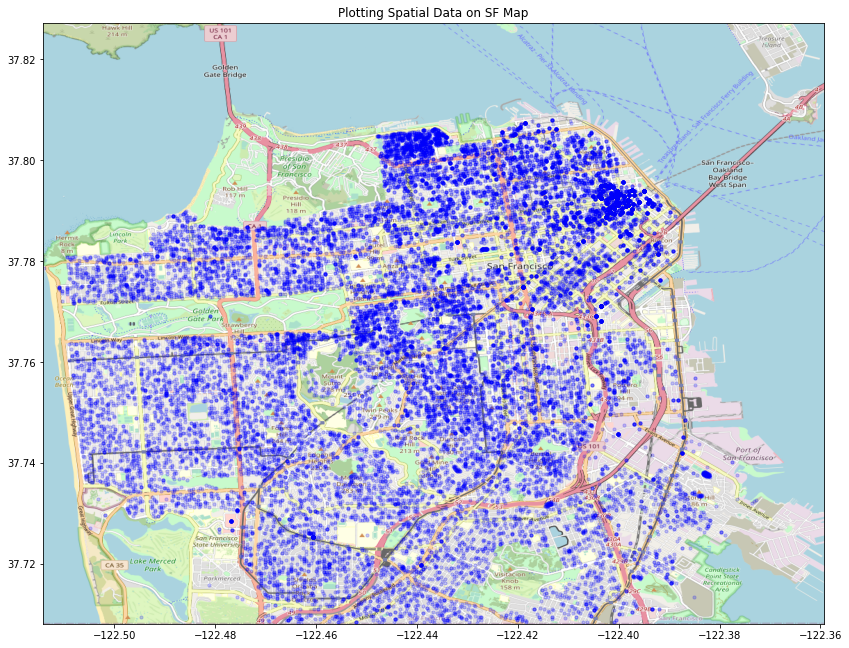

In [16]:
# Section demonstrates pulling data for the year 1990 
# and displaying a basic plotly map with a scatter plot of each buidling permit

bp['Location'].fillna("")

tuple = longlat(bp, 1990)

long = tuple[0]
lat = tuple[1]

series1 = pd.Series(long)
series2 = pd.Series(lat)

frame = {'longitude': long,'latitude': lat}

df_coor = pd.DataFrame(frame)

#Maximum and longitutude, latitude for the whole data set
BBox = (-122.5142, -122.3593, 37.7081, 37.8273)

sf_map = plt.imread(ipynb_path + '/sf_map.png')

zvals = [df_coor['longitude'],df_coor['latitude']]

fig, ax = plt.subplots(figsize = (14,12))

ax.scatter(df_coor['longitude'],df_coor['latitude'], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on SF Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(sf_map, zorder=0, extent = BBox)

In [17]:
# Creation of the bp_2017 Dataframe which is all the buidling permit data from after January 1st 2017 up to January 3rd 2024

bp_2017 = bp[bp['Filed Date'] > np.datetime64('2017-01-01')]
bp_2017 = bp_2017[bp_2017['Filed Date'] < np.datetime64('2024-01-03')]
bp_2017['Filed Date'].size


209098

In [18]:
# Below is the more advanced/interactive plotly express map of building permits used in the Dashboard

fig = px.scatter_mapbox(df_coor, lat=zvals[1], lon=zvals[0],
                  color_continuous_scale=px.colors.cyclical.IceFire)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [19]:
# Pulls the week and year values to their own column in the bp_2017 dataframe

bp_2017['Week'] = bp_2017['Filed Date'].dt.strftime('%V')
bp_2017['Year'] = bp_2017['Filed Date'].dt.strftime('%Y')
bp_2017['Week'] = bp_2017['Week'].replace(['53'],'52')

In [20]:
# Begins modifying data in the 'sf' dataframe aka. the Redfin housing data

for col in ['period_begin','period_end']:
    sf[col] = sf[col].astype('datetime64[ns]')

sf['Year'] = sf['period_begin'].dt.strftime('%Y')

In [21]:
# Pulls the week and year values and sorts by date in the sf dataframe

sf['Week'] = sf['period_end'].dt.strftime('%V')
sf['Year'] = sf['period_end'].dt.strftime('%Y')
sf.sort_values(by=['period_end'], inplace=True, ascending=True)

Below the adjusted_average_homes_sold is shifted down 4 weeks and the last 4 weeks are deleted

In [22]:
# Data for adjusted average homes sold is shifted 4 week in advance and the last 4 weeks of the dataset is dropped.
# This section enables time forcasting of the data 

sf['adjusted_average_homes_sold'] = sf['adjusted_average_homes_sold'].shift(-4)
sf.drop(index=sf.index[-4:], axis=0, inplace=True)

In [23]:
# This section matches the year and week information from bp_2017 dataframe and assigns the corresponding (4 week ahead) 
# average adjusted homes sold value from the sf dataframe

lst = []

series1 = bp_2017['Week']
series2 = bp_2017['Year']

for i in range(len(bp_2017)):
    
    x = sf["adjusted_average_homes_sold"][(sf["Year"] == series2.iat[i]) & (sf["Week"] == (series1.iat[i]))]
    x = x.values

    if len(x) != 0:
        x = x[0]
    else:
        x = 208.0
        
    lst.append(int(x))

series3 = pd.Series(lst)
bp_2017['adjusted_average_homes_sold'] = lst

In [24]:
# The bp_2017 is sorted by each building permit file date (earliest = first)

bp_2017.sort_values(by=['Filed Date'], inplace=True, ascending=True)

In [25]:
# Drops the na zipcode and neighborhood data from the dataset

bp_2017.drop(bp_2017[bp_2017['Zipcode'].isna()].index, inplace=True)
bp_2017.drop(bp_2017[bp_2017['Neighborhoods'].isna()].index, inplace=True)

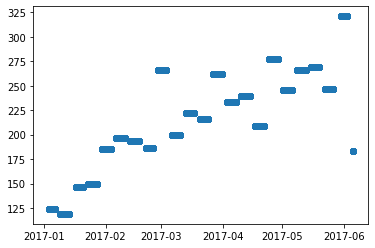

In [26]:
# Plot of the first ~ 6 months of buidling permit data to reveal data trend

fig, ax = plt.subplots()
ax.scatter(bp_2017['Filed Date'][:15000], bp_2017['adjusted_average_homes_sold'][:15000])

In [27]:
# Percentage of values in the dataframe that are null
bp_2017.isnull().sum()/len(bp_2017)

Record ID                        0.000000
Permit Type                      0.000000
Permit Creation Date             0.000000
Block                            0.000000
Lot                              0.000000
Current Status                   0.000000
Current Status Date              0.000000
Filed Date                       0.000000
Issued Date                      0.000000
Existing Occupancy               0.165262
Proposed Occupancy               0.168218
Last Permit Activity Date        0.000000
Application Submission Method    0.000000
ADU                              0.000000
Primary Address Flag             0.080216
Zipcode                          0.000000
Location                         0.000000
Neighborhoods                    0.000000
Wait Time                        0.000000
Filed Year                       0.000000
Week                             0.000000
Year                             0.000000
adjusted_average_homes_sold      0.000000
dtype: float64

In [28]:
# Splits of the data into five separate training and test sets. 
# The first set is trained on six years of data (2017 to 2023.) 
# The second set is trained on three years (2017 to 2022.)
# The third set is trained on four years (2017 to 2021)
# The fourth set is trained on three years (2017 to 2020)
# The fifth set is trained on two years (2017 to 2019)

split_date = '2023-01-01'
split_date2 = '2022-01-01'
split_date3 = '2021-01-01'
split_date4 = '2020-01-01'
split_date5 = '2019-01-01'

for col in ['Permit Type','Block','Lot','Current Status','Zipcode','Neighborhoods']:
    bp_2017[col] = bp_2017[col].astype(str)
    
bp_2017['Wait Time'].fillna('0', inplace=True)
    
for col in ['Year','Wait Time']:
    bp_2017[col] = bp_2017[col].astype('int64')
    
bp_2017 = bp_2017.drop(columns=['Location','Permit Creation Date','Current Status Date','Issued Date','Filed Year','Week'])

    
bp_train = bp_2017.loc[bp_2017['Filed Date'] <= split_date].copy()
bp_test = bp_2017.loc[bp_2017['Filed Date'] > split_date].copy()

bp_train2 = bp_2017.loc[bp_2017['Filed Date'] <= split_date2].copy()
bp_test2 = bp_2017.loc[bp_2017['Filed Date'] > split_date2].copy()

bp_train3 = bp_2017.loc[bp_2017['Filed Date'] <= split_date3].copy()
bp_test3 = bp_2017.loc[bp_2017['Filed Date'] > split_date3].copy()

bp_train4 = bp_2017.loc[bp_2017['Filed Date'] <= split_date4].copy()
bp_test4 = bp_2017.loc[bp_2017['Filed Date'] > split_date4].copy()

bp_train5 = bp_2017.loc[bp_2017['Filed Date'] <= split_date5].copy()
bp_test5 = bp_2017.loc[bp_2017['Filed Date'] > split_date5].copy()

In [29]:
# Creates the features (mostly date information) to be fed into the XGBoost algorithm

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['permit_type'] = df['Permit Type']
    df['dayofweek'] = df['Filed Date'].dt.dayofweek
    df['quarter'] = df['Filed Date'].dt.quarter
    df['month'] = df['Filed Date'].dt.month
    df['year'] = df['Filed Date'].dt.year
    df['dayofyear'] = df['Filed Date'].dt.dayofyear
    df['dayofmonth'] = df['Filed Date'].dt.day
    df['weekofyear'] = pd.to_datetime(df['Filed Date']).dt.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype('int64')

    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [30]:
X_train, y_train = create_features(bp_train, label='adjusted_average_homes_sold')

print(X_train.dtypes)
print(X_train['weekofyear'])

dayofweek     int64
quarter       int64
month         int64
year          int64
dayofyear     int64
dayofmonth    int64
weekofyear    int64
dtype: object
114834      1
112682      1
108589      1
111044      1
1039042     1
           ..
180484     52
31609      52
182962     52
1109142    52
1111542    52
Name: weekofyear, Length: 186777, dtype: int64


In [31]:
# Creation of features on data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

X_train, y_train = create_features(bp_train, label='adjusted_average_homes_sold')
X_test, y_test = create_features(bp_test, label='adjusted_average_homes_sold')


X_train2, y_train2 = create_features(bp_train2, label='adjusted_average_homes_sold')
X_test2, y_test2 = create_features(bp_test2, label='adjusted_average_homes_sold')


X_train3, y_train3 = create_features(bp_train3, label='adjusted_average_homes_sold')
X_test3, y_test3 = create_features(bp_test3, label='adjusted_average_homes_sold')


X_train4, y_train4 = create_features(bp_train4, label='adjusted_average_homes_sold')
X_test4, y_test4 = create_features(bp_test4, label='adjusted_average_homes_sold')


X_train5, y_train5 = create_features(bp_train5, label='adjusted_average_homes_sold')
X_test5, y_test5 = create_features(bp_test5, label='adjusted_average_homes_sold')


In [32]:
# Creation of five different XGBoost algorithms using the five different sets of training and test data

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

reg2 = xgb.XGBRegressor(n_estimators=1000)
reg2.fit(X_train2, y_train2,
        eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        early_stopping_rounds=50,
       verbose=False)

reg3 = xgb.XGBRegressor(n_estimators=1000)
reg3.fit(X_train3, y_train3,
        eval_set=[(X_train3, y_train3), (X_test3, y_test3)],
        early_stopping_rounds=50,
       verbose=False)

reg4 = xgb.XGBRegressor(n_estimators=1000)
reg4.fit(X_train4, y_train4,
        eval_set=[(X_train4, y_train4), (X_test4, y_test4)],
        early_stopping_rounds=50,
       verbose=False)

reg5 = xgb.XGBRegressor(n_estimators=1000)
reg5.fit(X_train5, y_train5,
        eval_set=[(X_train5, y_train5), (X_test5, y_test5)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\Sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

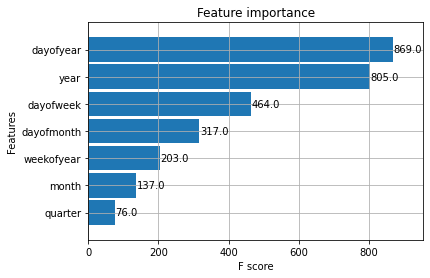

In [33]:
#Displaying of feautre importance in the first 'reg' algorithm

displt = plot_importance(reg, height=0.9, max_num_features=20)

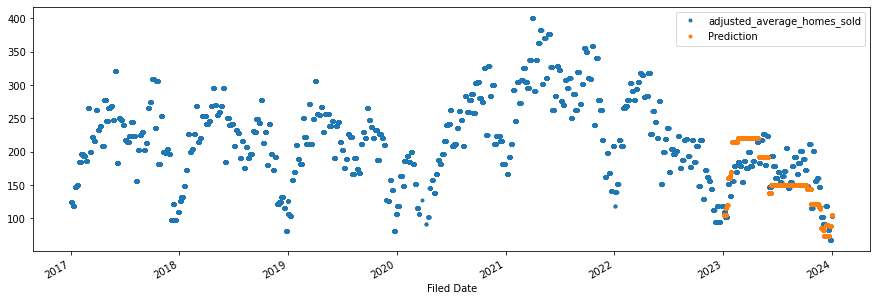

In [34]:
# Graph showing the first prediction model

bp_test['Prediction'] = reg.predict(X_test)
bp_all = pd.concat([bp_test, bp_train], sort=False)
_ = bp_all.plot(x='Filed Date',y=['adjusted_average_homes_sold','Prediction'],figsize=(15, 5), style='.')

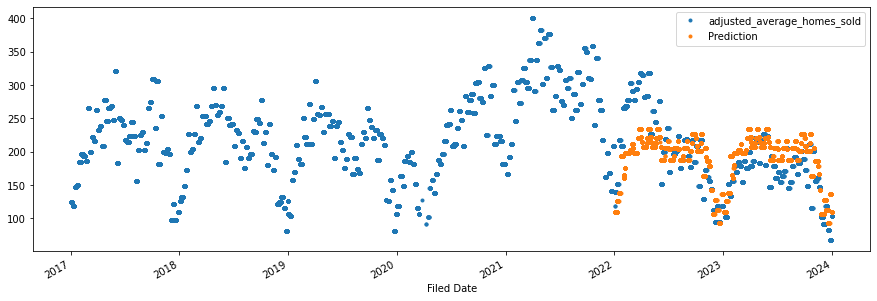

In [35]:
# Graph showing the second prediction model

bp_test2['Prediction'] = reg2.predict(X_test2)
bp_all2 = pd.concat([bp_test2, bp_train2], sort=False)
_ = bp_all2.plot(x='Filed Date',y=['adjusted_average_homes_sold','Prediction'],figsize=(15, 5), style='.')

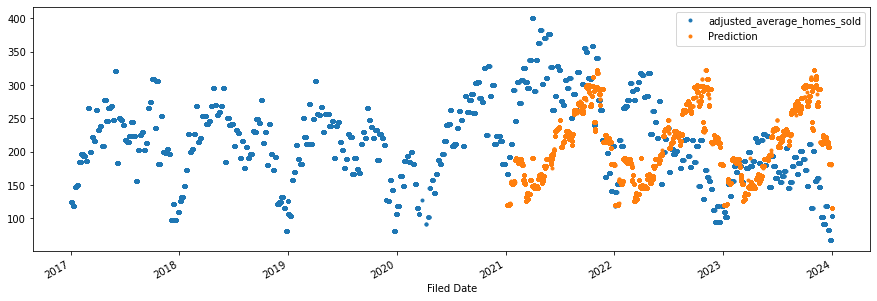

In [36]:
# Graph showing the third prediction model

bp_test3['Prediction'] = reg3.predict(X_test3)
bp_all3 = pd.concat([bp_test3, bp_train3], sort=False)
_ = bp_all3.plot(x='Filed Date',y=['adjusted_average_homes_sold','Prediction'],figsize=(15, 5), style='.')

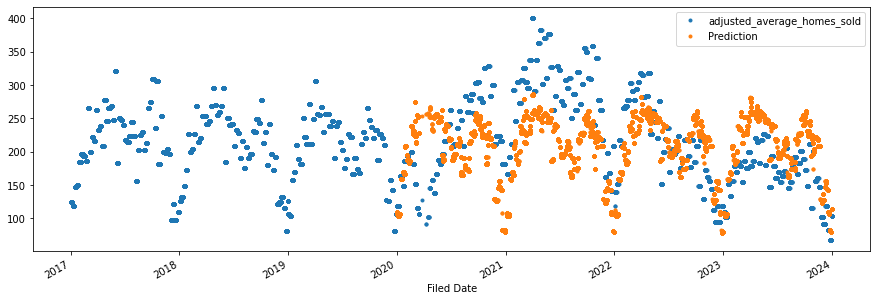

In [37]:
# Graph showing the fourth prediction model

bp_test4['Prediction'] = reg4.predict(X_test4)
bp_all4 = pd.concat([bp_test4, bp_train4], sort=False)
_ = bp_all4.plot(x='Filed Date',y=['adjusted_average_homes_sold','Prediction'],figsize=(15, 5), style='.')

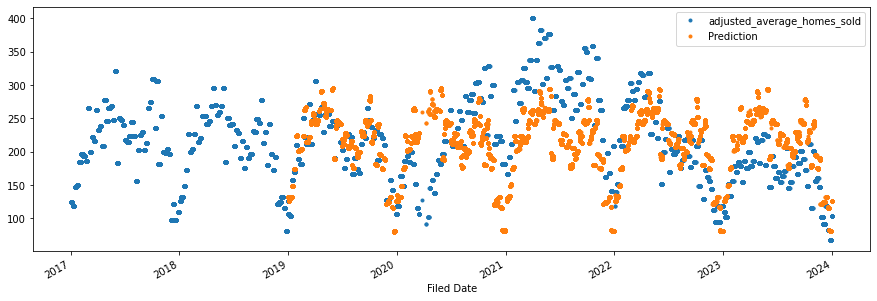

In [38]:
# Graph showing the fifth prediction model

bp_test5['Prediction'] = reg5.predict(X_test5)
bp_all5 = pd.concat([bp_test5, bp_train5], sort=False)
_ = bp_all5.plot(x='Filed Date',y=['adjusted_average_homes_sold','Prediction'],figsize=(15, 5), style='.')

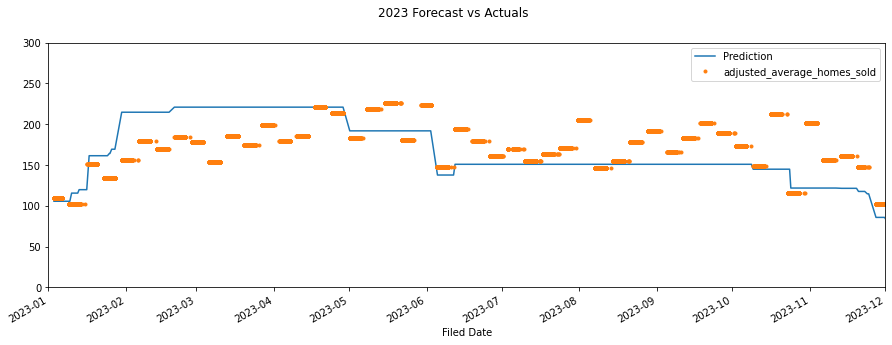

In [39]:
# Graph showing the first prediction model zoomed in on the last year of data (2023-01 to 2023-12)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = bp_all.plot(y=['Prediction','adjusted_average_homes_sold'],x='Filed Date',ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='12-01-2023')
ax.set_ylim(0, 300)
plot = plt.suptitle('2023 Forecast vs Actuals')

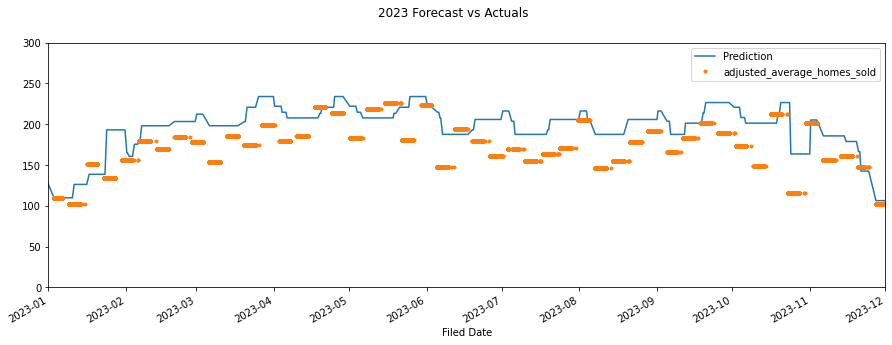

In [40]:
# Graph showing the second prediction model zoomed in on the last year of data (2023-01 to 2023-12)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = bp_all2.plot(y=['Prediction','adjusted_average_homes_sold'],x='Filed Date',ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='12-01-2023')
ax.set_ylim(0, 300)
plot = plt.suptitle('2023 Forecast vs Actuals')

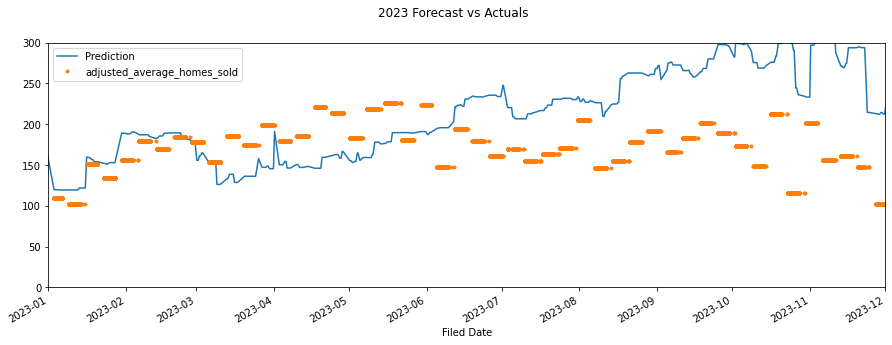

In [41]:
# Graph showing the third prediction model zoomed in on the last year of data (2023-01 to 2023-12)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = bp_all3.plot(y=['Prediction','adjusted_average_homes_sold'],x='Filed Date',ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='12-01-2023')
ax.set_ylim(0, 300)
plot = plt.suptitle('2023 Forecast vs Actuals')

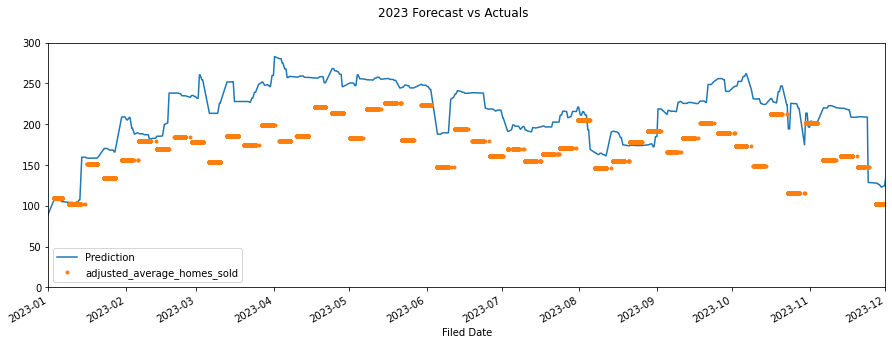

In [42]:
# Graph showing the fourth prediction model zoomed in on the last year of data (2023-01 to 2023-12)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = bp_all4.plot(y=['Prediction','adjusted_average_homes_sold'],x='Filed Date',ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='12-01-2023')
ax.set_ylim(0, 300)
plot = plt.suptitle('2023 Forecast vs Actuals')

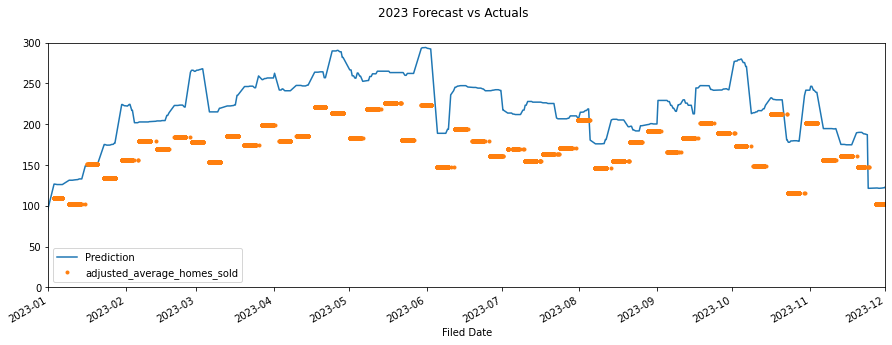

In [43]:
# Graph showing the third prediction model zoomed in on the last year of data (2023-01 to 2023-12)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = bp_all5.plot(y=['Prediction','adjusted_average_homes_sold'],x='Filed Date',ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='12-01-2023')
ax.set_ylim(0, 300)
plot = plt.suptitle('2023 Forecast vs Actuals')

In [44]:
# Fucntion defined to find the mean average percentage error of the predictions
# The mean average percentage error for the first model is shown below
def mape(y_t, y_p):
    y_t, y_p = np.array(y_t), np.array(y_p)
    return np.mean(np.abs(y_t - y_p)/ y_t) * 100

mape(y_t=bp_test['adjusted_average_homes_sold'],y_p=bp_test['Prediction'])


16.413303392898662

In [45]:
# The mean average percentage error for the second model is shown below

mape(y_t=bp_test2['adjusted_average_homes_sold'],y_p=bp_test2['Prediction'])

16.770891379764876

In [46]:
# The mean average percentage error for the third model is shown below

mape(y_t=bp_test3['adjusted_average_homes_sold'],y_p=bp_test3['Prediction'])

38.24109228531334

In [47]:
# The mean average percentage error for the fourth model is shown below

mape(y_t=bp_test4['adjusted_average_homes_sold'],y_p=bp_test4['Prediction'])

24.694844745019452

In [48]:
# The mean average percentage error for the fifth model is shown below

mape(y_t=bp_test5['adjusted_average_homes_sold'],y_p=bp_test5['Prediction'])

20.241543495595867

Using the date and time of building permits that are filed in the city of San Francisco five different models were created using XGBoost to predict/forecast the number of homes sold (1 month into the future) in the San Francisco metro area using different time periods to train each model. Not surprisingly the models with the larger amount of training data (2017 to end of 2022, 2017 to end of 2021) had the best predictions based on mean average percentage error. The worst performing model was trained on permit data from 2017 until the end of 2021. As shown by the graphs of the predictions years of 2020, 2021 and 2022 were the most abnormal where the number/timing of building permits were not as indicative of homes sold. This makes sense given the abnormal housing market caused by the Corona virus pandemic starting in March 2020. 

Based on the topology of the predictions vs. actual homes sold it appears that 2023 is returning to a more normal yearly cycle of homes sold comparable to years 2017, 2018 and 2019. Another insight is that consistently (even during the pandemic) the numbner of homes sold drops consistently during the weeks leading up to and following the new year as well as during the middle of the summer specifically around June 1st. 

Overall using building permit data is a consistent way to predict the homes sold in the city of San Francisco with reasonable certainty. 